In [1]:
from __future__ import print_function

import sys
import socket

if socket.gethostname() == "qiaubuntu" or socket.gethostname() == "toologic-ubuntu2":
    sys.path.extend(['/home/jorg/repository/dcnn_acdc'])
else:
    sys.path.extend(['/home/jorg/repo/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.detector.detector_dataset import RegionDetectorDataSet
from config.config import config as config_acdc
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from plotting.seg_errors_and_maps import plot_slices
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.detector.box_utils import find_bbox_object, BoundingBox
from utils.detector.batch_handler import BatchHandler
from utils.detector.experiment import Experiment
from utils.detector.exper_handler import ExperimentHandler

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config_detector.exper_dict_brier)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


In [ ]:
fold_id = 0
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]
exper_handler.get_test_set()

patient_id=None #  "patient078"
print("INFO - Generating dt maps. May take a while...")
_ = exper_handler.generate_dt_maps(patient_id=patient_id, adjust_to_roi=True)
print("INFO - Generating target rois. May take a while...")
_ = exper_handler.generate_target_rois_for_learning(patient_id=patient_id, mc_dropout=False)
print("INFO - Ready")

100%|██████████| 25/25 [00:01<00:00, 13.86it/s]


506.0 5320.0
12 7695 2709.0 2800.490566037736


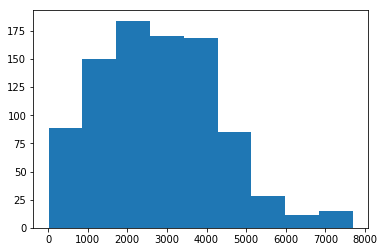

In [6]:
from common.detector.box_utils import BoundingBox

areas_es, areas_ed = [], []
fold_ids = [0, 1, 2, 3]

for fold_id in fold_ids:
    exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]
    exper_handler.get_test_set()
    exper_handler.test_set.generate_bbox_target_roi()
    target_roi_slices = exper_handler.test_set.labels_target_roi
    for patient_id, pat_slice_rois in target_roi_slices.iteritems():
        # print(patient_id, pat_slice_rois.keys()) 
        for slice_id, slice_rois in pat_slice_rois.iteritems():
            # first index ES/ED, second index slice_x, slice_y
            roi_box_es = BoundingBox(slice_rois[0][0], slice_rois[0][1])
            roi_box_ed = BoundingBox(slice_rois[1][0], slice_rois[1][1])
            area = roi_box_es.width * roi_box_es.height
            if area != 0:
                # if area < 567 or area > 5698:
                    # print(patient_id, area, slice_id)
                areas_es.append(area)
            area = roi_box_ed.width * roi_box_ed.height
            if area != 0:
                areas_ed.append(area)
    
    exper_handler.test_set = None
    
areas_es = np.array(areas_es)
lower, upper = np.percentile(areas_es, [5, 95], axis=0)
print(lower, upper)
print(np.min(areas_es), np.max(areas_es), np.median(areas_es), np.mean(areas_es))
_ = plt.hist(areas_es, bins=9)            
plt.show()